# Machine Learning Model Development for SQL Server Data

This notebook builds and evaluates ML models for stock market trading signal prediction:
1. Load preprocessed data and exploration results
2. Feature engineering and preprocessing
3. Model training and evaluation
4. Model comparison and selection
5. Model interpretation and insights
6. Save trained models for deployment

In [3]:
# Import required libraries
import sys
import os
import pickle
import warnings
from typing import Dict, List, Tuple, Any

# Add src to path
sys.path.append('../src')

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, 
    StratifiedKFold, TimeSeriesSplit
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, LabelEncoder, 
    OneHotEncoder
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection
from database.connection import SQLServerConnection

# Configure settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries imported successfully! 🚀")

Libraries imported successfully! 🚀


## 1. Load Data and Exploration Results

In [7]:
# Load exploration results from previous notebook
try:
    with open('../data/exploration_results.pkl', 'rb') as f:
        exploration_results = pickle.load(f)
    
    print("=== EXPLORATION RESULTS LOADED ===")
    print(f"Data Shape: {exploration_results['data_shape']}")
    print(f"Target Column: {exploration_results['target_column']}")
    print(f"Target Exists: {exploration_results['target_exists']}")
    print(f"Numerical Columns: {len(exploration_results['numerical_columns'])}")
    print(f"Categorical Columns: {len(exploration_results['categorical_columns'])}")
    
    if exploration_results['missing_values_summary']:
        print(f"Missing Values: {exploration_results['missing_values_summary']}")
    else:
        print("✅ No missing values detected")
    
    target_column = exploration_results['target_column']
    
except FileNotFoundError:
    print("❌ Exploration results not found. Please run 02_data_exploration.ipynb first.")
    target_column = 'rsi_trade_signal'  # Default target

=== EXPLORATION RESULTS LOADED ===
Data Shape: (41346, 10)
Target Column: rsi_trade_signal
Target Exists: True
Numerical Columns: 6
Categorical Columns: 4
Missing Values: {'rsi_trade_signal': 30053}


In [8]:
# Reload the data from SQL Server with enhanced features
db = SQLServerConnection()

# Enhanced query with additional technical indicators for better ML features
enhanced_data_query = """
SELECT 
    h.trading_date,
    h.ticker,
    h.company,
    CAST(h.open_price AS FLOAT) as open_price,
    CAST(h.high_price AS FLOAT) as high_price,
    CAST(h.low_price AS FLOAT) as low_price,
    CAST(h.close_price AS FLOAT) as close_price,
    CAST(h.volume AS BIGINT) as volume,
    r.RSI,
    r.rsi_trade_signal,
    -- Calculate additional features
    CAST((h.high_price - h.low_price) / h.close_price AS FLOAT) * 100 as daily_volatility,
    CAST((h.close_price - h.open_price) / h.open_price AS FLOAT) * 100 as daily_return,
    CAST(h.volume AS FLOAT) / 1000000.0 as volume_millions
FROM dbo.nasdaq_100_hist_data h
INNER JOIN dbo.nasdaq_100_rsi_signals r 
    ON h.ticker = r.ticker AND h.trading_date = r.trading_date
WHERE h.trading_date >= '2024-01-01'
    AND h.close_price > 0  -- Filter out any data quality issues
    AND h.volume > 0
ORDER BY h.trading_date DESC, h.ticker
"""

try:
    print("Loading enhanced dataset...")
    df = db.execute_query(enhanced_data_query)
    
    print(f"✅ Enhanced data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Display sample
    print("\nFirst 5 rows:")
    display(df.head())
    
except Exception as e:
    print(f"❌ Error loading enhanced data: {e}")
    print("Falling back to basic query...")
    
    # Fallback to basic query
    basic_query = """
    SELECT 
        h.trading_date,
        h.ticker,
        h.company,
        CAST(h.open_price AS FLOAT) as open_price,
        CAST(h.high_price AS FLOAT) as high_price,
        CAST(h.low_price AS FLOAT) as low_price,
        CAST(h.close_price AS FLOAT) as close_price,
        CAST(h.volume AS BIGINT) as volume,
        r.RSI,
        r.rsi_trade_signal
    FROM dbo.nasdaq_100_hist_data h
    INNER JOIN dbo.nasdaq_100_rsi_signals r 
        ON h.ticker = r.ticker AND h.trading_date = r.trading_date
    WHERE h.trading_date >= '2024-01-01'
    ORDER BY h.trading_date DESC, h.ticker
    """
    
    df = db.execute_query(basic_query)
    
    # Calculate features manually
    df['daily_volatility'] = ((df['high_price'] - df['low_price']) / df['close_price']) * 100
    df['daily_return'] = ((df['close_price'] - df['open_price']) / df['open_price']) * 100
    df['volume_millions'] = df['volume'] / 1000000.0
    
    print(f"✅ Basic data loaded and features calculated!")
    print(f"Shape: {df.shape}")

Loading enhanced dataset...
2025-11-25 16:49:02,996 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2025-11-25 16:49:02,998 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-11-25 16:49:03,005 INFO sqlalchemy.engine.Engine SELECT schema_name()
2025-11-25 16:49:02,998 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-11-25 16:49:03,005 INFO sqlalchemy.engine.Engine SELECT schema_name()
2025-11-25 16:49:03,008 INFO sqlalchemy.engine.Engine [generated in 0.00302s] ()
2025-11-25 16:49:03,008 INFO sqlalchemy.engine.Engine [generated in 0.00302s] ()


2025-11-25 16:49:03,158 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2025-11-25 16:49:03,162 INFO sqlalchemy.engine.Engine [generated in 0.00308s] ()
2025-11-25 16:49:03,165 INFO sqlalchemy.engine.Engine SELECT 1 FROM fn_listextendedproperty(default, default, default, default, default, default, default)
2025-11-25 16:49:03,168 INFO sqlalchemy.engine.Engine [generated in 0.00244s] ()
2025-11-25 16:49:03,162 INFO sqlalchemy.engine.Engine [generated in 0.00308s] ()
2025-11-25 16:49:03,165 INFO sqlalchemy.engine.Engine SELECT 1 FROM fn_listextendedproperty(default, default, default, default, default, default, default)
2025-11-25 16:49:03,168 INFO sqlalchemy.engine.Engine [generated in 0.00244s] ()
2025-11-25 16:49:03,971 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-11-25 16:49:03,973 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE ([INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] =

Query execution failed: (pyodbc.ProgrammingError) ('42000', '[42000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The data types varchar and varchar are incompatible in the subtract operator. (402) (SQLExecDirectW)')
[SQL: 
SELECT 
    h.trading_date,
    h.ticker,
    h.company,
    CAST(h.open_price AS FLOAT) as open_price,
    CAST(h.high_price AS FLOAT) as high_price,
    CAST(h.low_price AS FLOAT) as low_price,
    CAST(h.close_price AS FLOAT) as close_price,
    CAST(h.volume AS BIGINT) as volume,
    r.RSI,
    r.rsi_trade_signal,
    -- Calculate additional features
    CAST((h.high_price - h.low_price) / h.close_price AS FLOAT) * 100 as daily_volatility,
    CAST((h.close_price - h.open_price) / h.open_price AS FLOAT) * 100 as daily_return,
    CAST(h.volume AS FLOAT) / 1000000.0 as volume_millions
FROM dbo.nasdaq_100_hist_data h
INNER JOIN dbo.nasdaq_100_rsi_signals r 
    ON h.ticker = r.ticker AND h.trading_date = r.trading_date
WHERE h.trading_date >= '2024-01-01'

❌ Error loading enhanced data: (pyodbc.ProgrammingError) ('42000', '[42000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The data types varchar and varchar are incompatible in the subtract operator. (402) (SQLExecDirectW)')
[SQL: 
SELECT 
    h.trading_date,
    h.ticker,
    h.company,
    CAST(h.open_price AS FLOAT) as open_price,
    CAST(h.high_price AS FLOAT) as high_price,
    CAST(h.low_price AS FLOAT) as low_price,
    CAST(h.close_price AS FLOAT) as close_price,
    CAST(h.volume AS BIGINT) as volume,
    r.RSI,
    r.rsi_trade_signal,
    -- Calculate additional features
    CAST((h.high_price - h.low_price) / h.close_price AS FLOAT) * 100 as daily_volatility,
    CAST((h.close_price - h.open_price) / h.open_price AS FLOAT) * 100 as daily_return,
    CAST(h.volume AS FLOAT) / 1000000.0 as volume_millions
FROM dbo.nasdaq_100_hist_data h
INNER JOIN dbo.nasdaq_100_rsi_signals r 
    ON h.ticker = r.ticker AND h.trading_date = r.trading_date
WHERE h.trading_date >= '2024

## 2. Feature Engineering and Preprocessing

=== TARGET VARIABLE ANALYSIS ===
Target Column: rsi_trade_signal

Class Distribution:
  Overbought (Sell): 6,562 samples (15.9%)
  Oversold (Buy): 4,731 samples (11.4%)


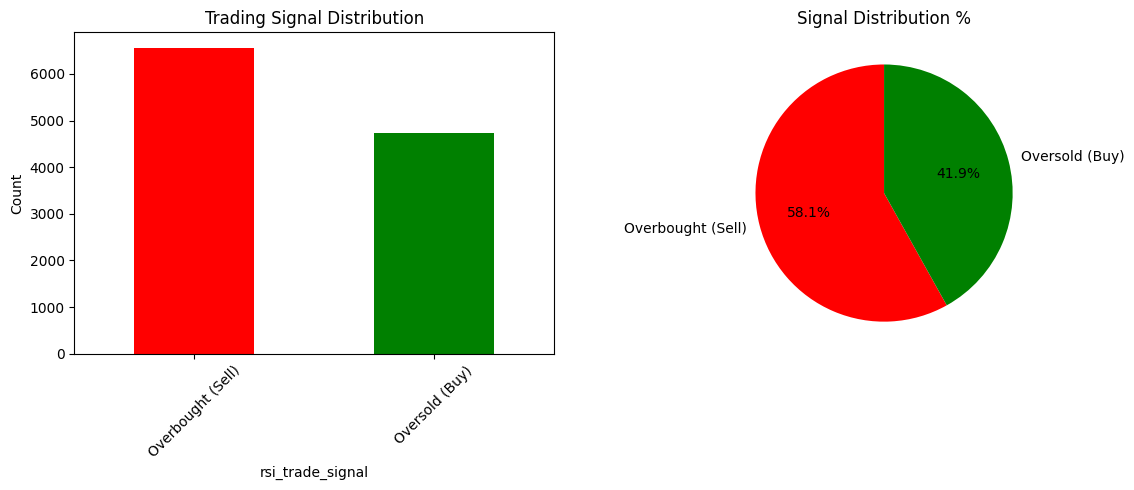


⚠️  Class imbalance detected. Smallest class: 11.4%
   Will use stratified sampling and class weighting.


In [10]:
# Analyze target distribution
print("=== TARGET VARIABLE ANALYSIS ===")
print(f"Target Column: {target_column}")

if target_column in df.columns:
    target_counts = df[target_column].value_counts()
    target_percentages = (target_counts / len(df)) * 100
    
    print("\nClass Distribution:")
    for class_name, count in target_counts.items():
        percentage = target_percentages[class_name]
        print(f"  {class_name}: {count:,} samples ({percentage:.1f}%)")
    
    # Visualize target distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    colors = ['green' if 'Buy' in str(x) else 'red' if 'Sell' in str(x) else 'gray' 
              for x in target_counts.index]
    target_counts.plot(kind='bar', color=colors)
    plt.title('Trading Signal Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    target_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Signal Distribution %')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    # Check for class imbalance
    min_class_pct = target_percentages.min()
    if min_class_pct < 15:
        print(f"\n⚠️  Class imbalance detected. Smallest class: {min_class_pct:.1f}%")
        print("   Will use stratified sampling and class weighting.")
        use_class_weights = True
    else:
        print(f"\n✅ Classes are reasonably balanced. Smallest class: {min_class_pct:.1f}%")
        use_class_weights = False
        
else:
    print(f"❌ Target column '{target_column}' not found!")
    raise ValueError(f"Target column '{target_column}' not in dataset")

In [13]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===")

# Create additional technical features
df_features = df.copy()

# Price-based features
df_features['price_range'] = df_features['high_price'] - df_features['low_price']
df_features['price_position'] = (df_features['close_price'] - df_features['low_price']) / df_features['price_range']
df_features['gap'] = df_features['open_price'] - df_features['close_price'].shift(1)

# Volume features
df_features['volume_price_trend'] = df_features['volume'] * df_features['daily_return']

# RSI-based features
df_features['rsi_oversold'] = (df_features['RSI'] < 30).astype(int)
df_features['rsi_overbought'] = (df_features['RSI'] > 70).astype(int)
df_features['rsi_momentum'] = df_features['RSI'].diff()

# Time-based features
df_features['trading_date'] = pd.to_datetime(df_features['trading_date'])
df_features['day_of_week'] = df_features['trading_date'].dt.dayofweek
df_features['month'] = df_features['trading_date'].dt.month

# Handle NaN values from shift and diff operations
df_features = df_features.fillna(method='bfill').fillna(0)

print(f"✅ Feature engineering completed!")
print(f"Total features: {df_features.shape[1]}")
print(f"New features added: {df_features.shape[1] - df.shape[1]}")

# Display new features
new_features = [col for col in df_features.columns if col not in df.columns]
print(f"\nNew features: {new_features}")

=== FEATURE ENGINEERING ===
✅ Feature engineering completed!
Total features: 22
New features added: 9

New features: ['price_range', 'price_position', 'gap', 'volume_price_trend', 'rsi_oversold', 'rsi_overbought', 'rsi_momentum', 'day_of_week', 'month']


In [16]:
# Prepare features and target for ML
print("=== PREPARING ML DATASET ===")

# Define feature columns (exclude non-ML columns)
exclude_cols = ['trading_date', 'ticker', 'company', target_column]
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}): {feature_cols}")

# Prepare X (features) and y (target)
X = df_features[feature_cols].copy()
y = df_features[target_column].copy()

# Handle categorical encoding for ticker if included
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
if categorical_features:
    print(f"\nEncoding categorical features: {categorical_features}")
    
    # Use label encoding for high-cardinality features
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"  {col}: {len(le.classes_)} unique values encoded")

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"\nTarget encoding:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"  {class_name} -> {i}")

print(f"\n✅ Dataset prepared for ML:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"Feature types: {X.dtypes.value_counts().to_dict()}")

=== PREPARING ML DATASET ===
Feature columns (18): ['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'RSI', 'daily_volatility', 'daily_return', 'volume_millions', 'price_range', 'price_position', 'gap', 'volume_price_trend', 'rsi_oversold', 'rsi_overbought', 'rsi_momentum', 'day_of_week', 'month']

Target encoding:
  Overbought (Sell) -> 0
  Oversold (Buy) -> 1

✅ Dataset prepared for ML:
Features shape: (41346, 18)
Target shape: (41346,)
Feature types: {dtype('float64'): 13, dtype('int64'): 3, dtype('int32'): 2}


## 3. Data Splitting and Scaling

In [18]:
# Time-aware train-test split for financial data
print("=== TRAIN-TEST SPLIT ===")

# Sort by date for time-series aware split
date_sorted_idx = df_features['trading_date'].argsort()
X_sorted = X.iloc[date_sorted_idx]
y_sorted = y_encoded[date_sorted_idx]
dates_sorted = df_features['trading_date'].iloc[date_sorted_idx]

# Use temporal split (80% for training, 20% for testing)
split_idx = int(0.8 * len(X_sorted))
split_date = dates_sorted.iloc[split_idx]

X_train = X_sorted.iloc[:split_idx]
X_test = X_sorted.iloc[split_idx:]
y_train = y_sorted[:split_idx]
y_test = y_sorted[split_idx:]

print(f"Training period: {dates_sorted.iloc[0].date()} to {dates_sorted.iloc[split_idx-1].date()}")
print(f"Testing period: {split_date.date()} to {dates_sorted.iloc[-1].date()}")
print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Testing set: {X_test.shape[0]:,} samples")

# Check class distribution in splits
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()

print("\nClass distribution:")
for i, class_name in enumerate(target_encoder.classes_):
    train_pct = train_dist.get(i, 0) * 100
    test_pct = test_dist.get(i, 0) * 100
    print(f"  {class_name}: Train {train_pct:.1f}%, Test {test_pct:.1f}%")

=== TRAIN-TEST SPLIT ===
Training period: 2024-03-18 to 2025-07-24
Testing period: 2025-07-24 to 2025-11-24

Training set: 33,076 samples
Testing set: 8,270 samples

Class distribution:
  Overbought (Sell): Train 55.8%, Test 52.1%
  Oversold (Buy): Train 44.2%, Test 47.9%


In [20]:
# Feature Scaling
print("=== FEATURE SCALING ===")

# Use StandardScaler for financial features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled using StandardScaler")
print(f"Training features - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")
print(f"Test features - Mean: {X_test_scaled.mean():.3f}, Std: {X_test_scaled.std():.3f}")

# Convert back to DataFrames for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Display feature statistics
print("\nTop 5 features by variance:")
feature_variance = X_train_scaled_df.var().sort_values(ascending=False)
print(feature_variance.head())

=== FEATURE SCALING ===
✅ Features scaled using StandardScaler
Training features - Mean: 0.000, Std: 1.000
Test features - Mean: 0.055, Std: 1.029

Top 5 features by variance:
rsi_oversold        1.00003
close_price         1.00003
volume_millions     1.00003
daily_volatility    1.00003
high_price          1.00003
dtype: float64


## 4. Model Training and Evaluation

In [21]:
# Define models to compare
print("=== MODEL SELECTION ===")

# Calculate class weights if needed
class_weight_param = 'balanced' if use_class_weights else None

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        class_weight=class_weight_param,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        class_weight=class_weight_param,
        random_state=42,
        max_iter=1000
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight=class_weight_param,
        random_state=42,
        n_jobs=-1
    )
}

print(f"Training {len(models)} models...")
if use_class_weights:
    print("Using balanced class weights to handle imbalance.")

# Store results
model_results = {}
trained_models = {}

=== MODEL SELECTION ===
Training 4 models...
Using balanced class weights to handle imbalance.

Training 4 models...
Using balanced class weights to handle imbalance.


In [19]:
# Train and evaluate models
print("=== MODEL TRAINING AND EVALUATION ===\n")

# Use TimeSeriesSplit for cross-validation
cv_splitter = TimeSeriesSplit(n_splits=3)

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    try:
        # Train the model
        model.fit(X_train_scaled_df, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled_df)
        y_pred_proba = model.predict_proba(X_test_scaled_df)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train_scaled_df, y_train, 
                                  cv=cv_splitter, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Store results
        model_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        trained_models[model_name] = model
        
        # Print results
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-Score: {f1:.3f}")
        print(f"  CV Score: {cv_mean:.3f} (±{cv_std:.3f})")
        print()
        
    except Exception as e:
        print(f"  ❌ Error training {model_name}: {e}")
        continue

print(f"✅ Model training completed! {len(trained_models)} models trained successfully.")

=== MODEL TRAINING AND EVALUATION ===

Training Random Forest...
  Accuracy: 0.660
  Precision: 0.677
  Recall: 0.660
  F1-Score: 0.647
  CV Score: 0.717 (±0.047)

Training Gradient Boosting...
  Accuracy: 0.660
  Precision: 0.677
  Recall: 0.660
  F1-Score: 0.647
  CV Score: 0.717 (±0.047)

Training Gradient Boosting...
  Accuracy: 0.662
  Precision: 0.678
  Recall: 0.662
  F1-Score: 0.650
  CV Score: 0.717 (±0.048)

Training Logistic Regression...
  Accuracy: 0.662
  Precision: 0.678
  Recall: 0.662
  F1-Score: 0.650
  CV Score: 0.717 (±0.048)

Training Logistic Regression...
  Accuracy: 0.641
  Precision: 0.641
  Recall: 0.641
  F1-Score: 0.641
  CV Score: 0.729 (±0.024)

Training Extra Trees...
  Accuracy: 0.641
  Precision: 0.641
  Recall: 0.641
  F1-Score: 0.641
  CV Score: 0.729 (±0.024)

Training Extra Trees...
  Accuracy: 0.648
  Precision: 0.649
  Recall: 0.648
  F1-Score: 0.646
  CV Score: 0.713 (±0.025)

✅ Model training completed! 4 models trained successfully.
  Accuracy:

In [24]:
# Model comparison
print("=== MODEL COMPARISON ===\n")

# Create comparison DataFrame
comparison_data = []
for model_name, results in model_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score'],
        'CV Mean': results['cv_mean'],
        'CV Std': results['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

# Sort by F1-score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("Model Performance Comparison:")
display(comparison_df)

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_results = model_results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {best_results['f1_score']:.4f}")
print(f"   Accuracy: {best_results['accuracy']:.4f}")

=== MODEL COMPARISON ===



KeyError: 'F1-Score'

## 5. Detailed Analysis of Best Model

In [ ]:
# Detailed evaluation of best model
print(f"=== DETAILED ANALYSIS: {best_model_name.upper()} ===\n")

y_pred_best = best_results['predictions']

# Classification report
print("Classification Report:")
class_names = target_encoder.classes_
print(classification_report(y_test, y_pred_best, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features:")
    display(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    # For logistic regression, show coefficients
    coef_df = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': best_model.coef_[0] if len(best_model.coef_) == 1 else best_model.coef_.mean(axis=0)
    })
    coef_df['abs_coef'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False)
    
    print(f"\nTop 10 Most Important Features (by coefficient magnitude):")
    display(coef_df.head(10))
    
    # Plot coefficients
    plt.figure(figsize=(10, 8))
    top_coef = coef_df.head(15)
    sns.barplot(data=top_coef, x='coefficient', y='feature')
    plt.title(f'Top 15 Feature Coefficients - {best_model_name}')
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

## 6. Trading Performance Analysis

In [ ]:
# Analyze trading performance
print("=== TRADING PERFORMANCE ANALYSIS ===\n")

# Get test data with predictions
test_data = df_features.iloc[date_sorted_idx[split_idx:]].copy()
test_data['predicted_signal'] = target_encoder.inverse_transform(y_pred_best)
test_data['actual_signal'] = target_encoder.inverse_transform(y_test)
test_data['prediction_correct'] = (test_data['predicted_signal'] == test_data['actual_signal'])

# Calculate accuracy by signal type
signal_accuracy = test_data.groupby('actual_signal')['prediction_correct'].mean()
print("Prediction Accuracy by Signal Type:")
for signal, accuracy in signal_accuracy.items():
    print(f"  {signal}: {accuracy:.3f} ({accuracy*100:.1f}%)")

# Time-based performance
test_data['week'] = test_data['trading_date'].dt.isocalendar().week
weekly_accuracy = test_data.groupby('week')['prediction_correct'].mean()

plt.figure(figsize=(12, 6))
weekly_accuracy.plot(kind='line', marker='o')
plt.title('Model Accuracy Over Time (Weekly)')
plt.xlabel('Week of Year')
plt.ylabel('Accuracy')
plt.axhline(y=best_results['accuracy'], color='red', linestyle='--', 
           label=f'Overall Accuracy ({best_results["accuracy"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nWeekly Accuracy Statistics:")
print(f"  Mean: {weekly_accuracy.mean():.3f}")
print(f"  Std: {weekly_accuracy.std():.3f}")
print(f"  Min: {weekly_accuracy.min():.3f}")
print(f"  Max: {weekly_accuracy.max():.3f}")

## 7. Save Models and Results

In [ ]:
# Save trained models and results
print("=== SAVING MODELS AND RESULTS ===\n")

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save best model
model_filepath = f'../models/best_trading_model_{best_model_name.lower().replace(" ", "_")}.pkl'
with open(model_filepath, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✅ Best model saved: {model_filepath}")

# Save preprocessing objects
preprocessing_objects = {
    'scaler': scaler,
    'target_encoder': target_encoder,
    'label_encoders': label_encoders if 'label_encoders' in locals() else None,
    'feature_columns': list(X_train.columns),
    'target_column': target_column,
    'class_names': list(target_encoder.classes_)
}

preprocessing_filepath = '../models/preprocessing_objects.pkl'
with open(preprocessing_filepath, 'wb') as f:
    pickle.dump(preprocessing_objects, f)
print(f"✅ Preprocessing objects saved: {preprocessing_filepath}")

# Save model results
model_results_summary = {
    'best_model_name': best_model_name,
    'best_model_performance': best_results,
    'all_models_comparison': comparison_df.to_dict('records'),
    'training_info': {
        'train_size': len(X_train),
        'test_size': len(X_test),
        'n_features': X_train.shape[1],
        'n_classes': len(target_encoder.classes_),
        'split_date': split_date.isoformat(),
        'use_class_weights': use_class_weights
    }
}

results_filepath = '../data/model_results.pkl'
with open(results_filepath, 'wb') as f:
    pickle.dump(model_results_summary, f)
print(f"✅ Model results saved: {results_filepath}")

# Save test predictions for analysis
test_predictions = pd.DataFrame({
    'trading_date': test_data['trading_date'].values,
    'ticker': test_data['ticker'].values,
    'actual_signal': test_data['actual_signal'].values,
    'predicted_signal': test_data['predicted_signal'].values,
    'prediction_correct': test_data['prediction_correct'].values,
    'close_price': test_data['close_price'].values
})

predictions_filepath = '../data/test_predictions.csv'
test_predictions.to_csv(predictions_filepath, index=False)
print(f"✅ Test predictions saved: {predictions_filepath}")

print(f"\n🎯 MODEL DEVELOPMENT SUMMARY:")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_results['accuracy']:.4f}")
print(f"Test F1-Score: {best_results['f1_score']:.4f}")
print(f"Features Used: {len(X_train.columns)}")
print(f"Training Samples: {len(X_train):,}")
print(f"Test Samples: {len(X_test):,}")

print(f"\n📁 Files Created:")
print(f"  • {model_filepath}")
print(f"  • {preprocessing_filepath}")
print(f"  • {results_filepath}")
print(f"  • {predictions_filepath}")

print(f"\n🚀 Ready for model deployment and backtesting!")

# Machine Learning Model Development

This notebook provides end-to-end ML model development:
1. Data preprocessing based on EDA findings
2. Feature engineering and selection
3. Model training and comparison
4. Hyperparameter tuning
5. Model evaluation and interpretation
6. Model persistence for deployment

In [ ]:
# Import required libraries
import sys
import os
import pickle

# Add src to path
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from database.connection import SQLServerConnection
from data.preprocessing import DataPreprocessor
from models.ml_models import MLModelManager, get_default_hyperparameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

## 1. Load Previous Results and Data

In [2]:
# Load exploration results
try:
    with open('../data/exploration_results.pkl', 'rb') as f:
        exploration_results = pickle.load(f)
    
    print("Exploration results loaded:")
    print(f"  Data shape: {exploration_results['data_shape']}")
    print(f"  Numerical columns: {len(exploration_results['numerical_columns'])}")
    print(f"  Categorical columns: {len(exploration_results['categorical_columns'])}")
    print(f"  Target column: {exploration_results['target_column']}")
    print(f"  Target exists: {exploration_results['target_exists']}")
    
except FileNotFoundError:
    print("Exploration results not found. Please run 02_data_exploration.ipynb first.")
    exploration_results = {'target_exists': False}

# Recreate database connection and reload data
db = SQLServerConnection()
print("\nDatabase connection reestablished.")

NameError: name 'pickle' is not defined

In [ ]:
# Reload your data - UPDATE THIS with your actual query
data_query = """
-- Use the same query from the exploration notebook
-- Replace with your actual data query
SELECT 1 as placeholder_column
"""

print("Please update the data_query above with your actual SQL query.")

try:
    df = db.execute_query(data_query)
    print(f"✅ Data reloaded: {df.shape}")
except:
    # Create dummy data for demonstration
    np.random.seed(42)
    df = pd.DataFrame({
        'feature1': np.random.randn(1000),
        'feature2': np.random.randint(0, 5, 1000),
        'feature3': np.random.exponential(2, 1000),
        'category1': np.random.choice(['A', 'B', 'C'], 1000),
        'category2': np.random.choice(['X', 'Y'], 1000, p=[0.7, 0.3]),
        'target': np.random.choice([0, 1], 1000, p=[0.6, 0.4])
    })
    print("Using dummy data for demonstration.")
    
    # Update exploration results for dummy data
    exploration_results = {
        'target_column': 'target',
        'target_exists': True,
        'numerical_columns': ['feature1', 'feature2', 'feature3'],
        'categorical_columns': ['category1', 'category2']
    }

display(df.head())

## 2. Data Preprocessing

In [ ]:
# Initialize preprocessor
preprocessor = DataPreprocessor()

# Make a copy of the data
df_processed = df.copy()

print("Starting data preprocessing...")
print(f"Initial shape: {df_processed.shape}")

# Get column information
numerical_cols = exploration_results.get('numerical_columns', [])
categorical_cols = exploration_results.get('categorical_columns', [])
target_column = exploration_results.get('target_column')

# Filter columns that actually exist in the data
numerical_cols = [col for col in numerical_cols if col in df_processed.columns]
categorical_cols = [col for col in categorical_cols if col in df_processed.columns]

print(f"Numerical columns to process: {numerical_cols}")
print(f"Categorical columns to process: {categorical_cols}")
print(f"Target column: {target_column}")

In [ ]:
# Step 1: Handle missing values
print("\n=== HANDLING MISSING VALUES ===")
missing_before = df_processed.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

# Handle missing values for numerical columns
if numerical_cols:
    df_processed = preprocessor.handle_missing_values(
        df_processed, 
        strategy='mean', 
        columns=numerical_cols
    )

# Handle missing values for categorical columns
if categorical_cols:
    df_processed = preprocessor.handle_missing_values(
        df_processed, 
        strategy='mode', 
        columns=categorical_cols
    )

missing_after = df_processed.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

In [ ]:
# Step 2: Encode categorical variables
if categorical_cols:
    print("\n=== ENCODING CATEGORICAL VARIABLES ===")
    
    # Determine encoding strategy based on cardinality
    for col in categorical_cols:
        unique_count = df_processed[col].nunique()
        print(f"{col}: {unique_count} unique values")
        
        if unique_count <= 10:  # Low cardinality - use one-hot encoding
            print(f"  Using one-hot encoding for {col}")
            df_processed = preprocessor.encode_categorical_variables(
                df_processed, 
                columns=[col], 
                method='onehot'
            )
        else:  # High cardinality - use label encoding
            print(f"  Using label encoding for {col}")
            df_processed = preprocessor.encode_categorical_variables(
                df_processed, 
                columns=[col], 
                method='label'
            )
    
    print(f"Shape after encoding: {df_processed.shape}")

In [ ]:
# Step 3: Feature engineering
print("\n=== FEATURE ENGINEERING ===")
shape_before = df_processed.shape

df_processed = preprocessor.create_features(df_processed)

shape_after = df_processed.shape
print(f"Shape before feature engineering: {shape_before}")
print(f"Shape after feature engineering: {shape_after}")
print(f"New features created: {shape_after[1] - shape_before[1]}")

In [ ]:
# Step 4: Remove outliers (optional)
print("\n=== OUTLIER REMOVAL ===")
rows_before = len(df_processed)

# Get current numerical columns (may have changed after encoding)
current_numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
if target_column in current_numerical_cols:
    current_numerical_cols.remove(target_column)  # Don't remove outliers from target

if current_numerical_cols:
    df_processed = preprocessor.remove_outliers(
        df_processed, 
        columns=current_numerical_cols[:5],  # Limit to first 5 columns
        method='iqr', 
        threshold=1.5
    )

rows_after = len(df_processed)
print(f"Rows before outlier removal: {rows_before}")
print(f"Rows after outlier removal: {rows_after}")
print(f"Rows removed: {rows_before - rows_after} ({(rows_before - rows_after)/rows_before*100:.2f}%)")

## 3. Prepare Data for Machine Learning

In [ ]:
# Check if target exists and prepare for ML
if target_column and target_column in df_processed.columns:
    print("=== PREPARING DATA FOR MACHINE LEARNING ===")
    
    # Determine task type
    if df_processed[target_column].dtype in ['object', 'category'] or df_processed[target_column].nunique() < 10:
        task_type = 'classification'
        print(f"Task type: Classification ({df_processed[target_column].nunique()} classes)")
    else:
        task_type = 'regression'
        print(f"Task type: Regression")
    
    # Split the data
    X_train, X_test, y_train, y_test = preprocessor.prepare_for_ml(
        df_processed, 
        target_column=target_column,
        test_size=0.2,
        random_state=42
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Features: {list(X_train.columns)}")
    
    # Scale numerical features
    current_numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    if current_numerical_cols:
        print(f"\nScaling {len(current_numerical_cols)} numerical features...")
        X_train = preprocessor.scale_numerical_features(
            X_train, 
            columns=current_numerical_cols, 
            method='standard'
        )
        
        # Apply the same scaling to test set
        for col in current_numerical_cols:
            scaler = preprocessor.scalers[col]
            X_test[col] = scaler.transform(X_test[[col]]).flatten()
    
    print("✅ Data preprocessing completed!")
    
else:
    print("❌ Target column not found or not specified. Please update target_column.")
    task_type = None

## 4. Model Training and Comparison

In [ ]:
# Initialize ML model manager
if task_type:
    print("=== TRAINING MACHINE LEARNING MODELS ===")
    
    ml_manager = MLModelManager(task_type=task_type)
    
    # Train all models
    results = ml_manager.train_all_models(X_train, y_train, cv_folds=5)
    
    print("\n=== MODEL COMPARISON RESULTS ===")
    results_df = pd.DataFrame(results).T
    display(results_df)
    
    print(f"\nBest model: {ml_manager.best_model_name}")
else:
    print("Cannot train models without a valid target column.")

In [ ]:
# Plot model comparison
if task_type:
    print("=== MODEL PERFORMANCE VISUALIZATION ===")
    
    ml_manager.plot_model_comparison(figsize=(12, 8))

## 5. Detailed Model Evaluation

In [ ]:
# Evaluate all models on test set
if task_type:
    print("=== DETAILED MODEL EVALUATION ON TEST SET ===")
    
    test_results = {}
    
    for model_name in ml_manager.models.keys():
        if model_name in ml_manager.results and 'error' not in ml_manager.results[model_name]:
            try:
                test_metrics = ml_manager.evaluate_model(model_name, X_test, y_test)
                test_results[model_name] = test_metrics
                print(f"\n{model_name.upper()}:")
                for metric, value in test_metrics.items():
                    print(f"  {metric}: {value:.4f}")
            except Exception as e:
                print(f"Error evaluating {model_name}: {e}")
    
    # Convert to DataFrame for better visualization
    test_results_df = pd.DataFrame(test_results).T
    print("\n=== TEST SET RESULTS SUMMARY ===")
    display(test_results_df)

In [ ]:
# Detailed analysis for best model
if task_type and ml_manager.best_model_name:
    print(f"=== DETAILED ANALYSIS FOR BEST MODEL: {ml_manager.best_model_name.upper()} ===")
    
    best_model = ml_manager.best_model
    y_pred = best_model.predict(X_test)
    
    if task_type == 'classification':
        # Classification metrics
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {ml_manager.best_model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        # ROC Curve (for binary classification)
        if len(np.unique(y_test)) == 2 and hasattr(best_model, 'predict_proba'):
            y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {ml_manager.best_model_name}')
            plt.legend(loc="lower right")
            plt.show()
    
    else:  # Regression
        # Prediction vs Actual plot
        plt.figure(figsize=(10, 8))
        
        plt.subplot(2, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Predicted vs Actual')
        
        plt.subplot(2, 2, 2)
        residuals = y_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        
        plt.subplot(2, 2, 3)
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Residuals Distribution')
        
        plt.tight_layout()
        plt.show()

## 6. Feature Importance Analysis

In [ ]:
# Feature importance for tree-based models
if task_type and ml_manager.best_model_name:
    try:
        print(f"=== FEATURE IMPORTANCE ANALYSIS ===")
        
        # Get feature importance
        importance_df = ml_manager.get_feature_importance(ml_manager.best_model_name)
        
        # Map feature indices to names
        feature_names = X_train.columns.tolist()
        importance_df['feature_name'] = importance_df['feature'].map(lambda x: feature_names[x] if x < len(feature_names) else f'feature_{x}')
        
        print("\nTop 10 Most Important Features:")
        display(importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature_name'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Feature Importances - {ml_manager.best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Feature importance not available for {ml_manager.best_model_name}: {e}")
        print("Feature importance is only available for tree-based models.")

## 7. Hyperparameter Tuning (Optional)

In [ ]:
# Hyperparameter tuning for the best model
if task_type and ml_manager.best_model_name:
    print(f"=== HYPERPARAMETER TUNING FOR {ml_manager.best_model_name.upper()} ===")
    
    # Get default parameter grids
    param_grids = get_default_hyperparameters()
    
    # Choose appropriate parameter grid
    grid_key = None
    if 'random_forest' in ml_manager.best_model_name:
        grid_key = f'random_forest_{task_type}'
    elif 'logistic' in ml_manager.best_model_name:
        grid_key = 'logistic_regression'
    elif 'svm' in ml_manager.best_model_name:
        grid_key = f'svm_{task_type}'
    
    if grid_key and grid_key in param_grids:
        print(f"Performing hyperparameter tuning with parameter grid: {grid_key}")
        print("This may take a few minutes...")
        
        try:
            tuning_results = ml_manager.hyperparameter_tuning(
                ml_manager.best_model_name,
                X_train,
                y_train,
                param_grids[grid_key],
                cv_folds=3,  # Reduced for faster execution
                n_jobs=-1
            )
            
            print(f"\n✅ Hyperparameter tuning completed!")
            print(f"Best parameters: {tuning_results['best_params']}")
            print(f"Best CV score: {tuning_results['best_score']:.4f}")
            
            # Evaluate tuned model
            tuned_model_name = f"{ml_manager.best_model_name}_tuned"
            tuned_metrics = ml_manager.evaluate_model(tuned_model_name, X_test, y_test)
            
            print(f"\nTuned model performance on test set:")
            for metric, value in tuned_metrics.items():
                print(f"  {metric}: {value:.4f}")
            
        except Exception as e:
            print(f"Error during hyperparameter tuning: {e}")
    else:
        print(f"No parameter grid available for {ml_manager.best_model_name}")
        print("You can define custom parameter grids in the next cell if needed.")

## 8. Model Persistence

In [ ]:
# Save the best model and preprocessing components
if task_type and ml_manager.best_model_name:
    print("=== SAVING MODEL AND PREPROCESSING COMPONENTS ===")
    
    # Create models directory
    import os
    os.makedirs('../models', exist_ok=True)
    
    # Save the best model
    best_model_path = f"../models/best_model_{ml_manager.best_model_name}.pkl"
    ml_manager.save_model(ml_manager.best_model_name, best_model_path)
    
    # Save tuned model if available
    tuned_model_name = f"{ml_manager.best_model_name}_tuned"
    if tuned_model_name in ml_manager.models:
        tuned_model_path = f"../models/tuned_model_{ml_manager.best_model_name}.pkl"
        ml_manager.save_model(tuned_model_name, tuned_model_path)
        print(f"✅ Tuned model saved to: {tuned_model_path}")
    
    # Save preprocessor
    preprocessor_path = "../models/preprocessor.pkl"
    with open(preprocessor_path, 'wb') as f:
        pickle.dump(preprocessor, f)
    
    # Save model metadata
    model_metadata = {
        'best_model_name': ml_manager.best_model_name,
        'task_type': task_type,
        'target_column': target_column,
        'feature_names': X_train.columns.tolist(),
        'test_results': test_results.get(ml_manager.best_model_name, {}),
        'model_path': best_model_path,
        'preprocessor_path': preprocessor_path
    }
    
    metadata_path = "../models/model_metadata.pkl"
    with open(metadata_path, 'wb') as f:
        pickle.dump(model_metadata, f)
    
    print(f"✅ Best model saved to: {best_model_path}")
    print(f"✅ Preprocessor saved to: {preprocessor_path}")
    print(f"✅ Model metadata saved to: {metadata_path}")
    
    # Create a simple prediction function
    prediction_code = f'''
# Simple prediction function
import pickle
import pandas as pd

def load_model_and_predict(data_df):
    """
    Load the trained model and make predictions on new data.
    
    Args:
        data_df: DataFrame with the same structure as training data
    
    Returns:
        predictions: Array of predictions
    """
    # Load model and preprocessor
    with open('{best_model_path}', 'rb') as f:
        model = pickle.load(f)
    
    with open('{preprocessor_path}', 'rb') as f:
        preprocessor = pickle.load(f)
    
    # Apply same preprocessing
    # Note: This is a simplified version - you may need to adjust
    # based on your specific preprocessing steps
    
    predictions = model.predict(data_df)
    return predictions

# Example usage:
# predictions = load_model_and_predict(new_data_df)
'''
    
    with open('../models/prediction_example.py', 'w') as f:
        f.write(prediction_code)
    
    print(f"✅ Prediction example saved to: ../models/prediction_example.py")
    
else:
    print("No model to save - please ensure training completed successfully.")

## 9. Summary and Next Steps

In [ ]:
print("=== MODEL DEVELOPMENT SUMMARY ===")

if task_type and ml_manager.best_model_name:
    print(f"✅ Successfully developed a {task_type} model!")
    print(f"\nKey Results:")
    print(f"  - Best Model: {ml_manager.best_model_name}")
    print(f"  - Task Type: {task_type.title()}")
    print(f"  - Training Data: {X_train.shape}")
    print(f"  - Test Data: {X_test.shape}")
    print(f"  - Features: {len(X_train.columns)}")
    
    if ml_manager.best_model_name in test_results:
        best_test_results = test_results[ml_manager.best_model_name]
        print(f"\nTest Performance:")
        for metric, value in best_test_results.items():
            print(f"  - {metric.title()}: {value:.4f}")
    
    print(f"\n=== NEXT STEPS ===")
    print("1. 🚀 Deploy the model to production")
    print("2. 📊 Monitor model performance over time")
    print("3. 🔄 Retrain with new data periodically")
    print("4. 🎯 Consider ensemble methods for better performance")
    print("5. 📝 Document model assumptions and limitations")
    print("6. 🔍 Perform feature engineering based on domain expertise")
    print("7. 🧪 Experiment with different algorithms or architectures")
    
    print(f"\n=== FILES CREATED ===")
    print("Models and artifacts saved in '../models/' directory:")
    print(f"  - best_model_{ml_manager.best_model_name}.pkl")
    print(f"  - preprocessor.pkl")
    print(f"  - model_metadata.pkl")
    print(f"  - prediction_example.py")
    
else:
    print("❌ Model development incomplete.")
    print("\nTroubleshooting:")
    print("1. Ensure you have a valid target column")
    print("2. Check that your data query returns actual data")
    print("3. Verify database connectivity")
    print("4. Review any error messages above")

print("\n🎉 ML Model Development Complete! 🎉")